## Initial 'toy' system
I have implemented a modular system in pytorch, with the following:
  
1. **FIRFilter1D**:
   - Implements an arbitrary phase FIR filter using a 1D convolutional layer.
   - The filter taps are learnable parameters.

2. **FIRFilter1DLinearPhaseI**:
   - Implements a linear phase FIR type I filter using 1D convolution.
   - Only allows an odd number of taps and enforces type I symmetry in the filter taps.
   - Taps are learnable parameters (only from the mid-index and up).

3. **GammaToneFilter**:
   - Impulse response of the filter is computed based on specified parameters like center frequency, sampling frequency, and impairment factor
     - !Impairing like this makes no sense just something I did for the toy example.
   - The filter is applied to the input signal using a 1D convolutional layer.

4. **GammaToneFilterbank**:
   - Uses the `GammaToneFilter` module to create individual filters and applies them to the input signal as a filterbank.

5. **NormalModel**:
   - Uses a `GammaToneFilterBank` to process the input with no pre-gain (FIR filter).

6. **ImpairedModel**:
   - Uses a `FIRFilter1D` to apply a learnable gain filter to process which then gets processed by `GammaToneFilterBank`.
   - The gain filter is implemented using `FIRFilter1D`, I have not tried using `FIRFilter1DLinearPhaseI`, although it should work with no issues.

7. **MyModel_v1**:
   - A trainable model composed of a normal hearing model and an impaired hearing model.
   - Uses the `NormalModel` and `ImpairedModel` to process the input and produce outputs for normal and impaired hearing, respectively.

I have tried training a `NormalModel` using SGD with the SI-SDR loss between normal and impaired outputs as the loss function, which was successful. The results are presented under RESULTS below.

![Alt text](../image-11.png)
### Next steps

- [ ] Try to mimic how the DHASP paper implemented the diffrentiable perceptual model.
- [ ] Try to mimic how the DHASP paper implemented the diffrentiable hearing-aid processing model.
- [ ] Introduce a perceptual loss to optimize the NN.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

print(torch.__version__)

import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..")))
from tools import plot, utils
from tools.nn_modules import *
import numpy as np

import IPython.display as ipd

2.1.0+cpu


In [2]:
# helper functions
def plot_gammabank(bank, center_frequencies):
    freq_axes = []
    spec_axes = []
    time_signals = []
    for filter in bank.filters:
        h, f = utils.get_spectrum(filter.impulse_response, samplerate=samplerate)
        freq_axes.append(f)
        spec_axes.append(h)
        time_signals.append(filter.impulse_response)

    # Plot IR in time-domain and magnitude repsonse
    plot.magspec(
        freq_axes=freq_axes,
        spec_axes=spec_axes,
        title="Magnitude response",
        labels=center_frequencies,
    )
    plot.timeseries(
        time_signals,
        samplerate=samplerate,
        xlim=[0, 0.1],
        title="Impulse responses",
        labels=center_frequencies,
    )


def plot_time_and_spec(signals, samplerate, labels):
    
    freq_axes = []
    spec_axes = []
    for signal in signals:
        h, f = utils.get_spectrum(signal, samplerate=samplerate)
        freq_axes.append(f)
        spec_axes.append(h)

    # Plot IR in time-domain and magnitude repsonse
    plot.timeseries(
        signals, samplerate=samplerate, title="Input-output signals", labels=labels
    )
    plot.magspec(
        freq_axes=freq_axes, spec_axes=spec_axes, title="Spectra", labels=labels
    )


def batch_2_np(batch):
    return batch[0][0].detach().numpy()


def audio_play(signal, samplerate):
    return ipd.display(ipd.Audio(signal, rate=samplerate))  # load a NumPy array

In [3]:
# define parameters
samplerate = 22050
center_frequencies = [1000]
n_batch = 1
n_samples = 22050
n_channels = 1
taps = 160

Define the filterbank models for impaired and normal hearing listeners

Normal hearing filterbank


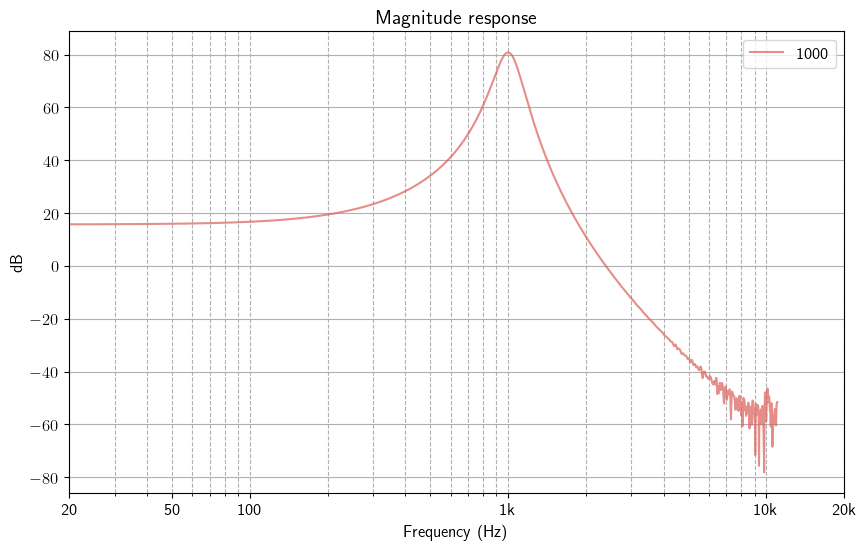

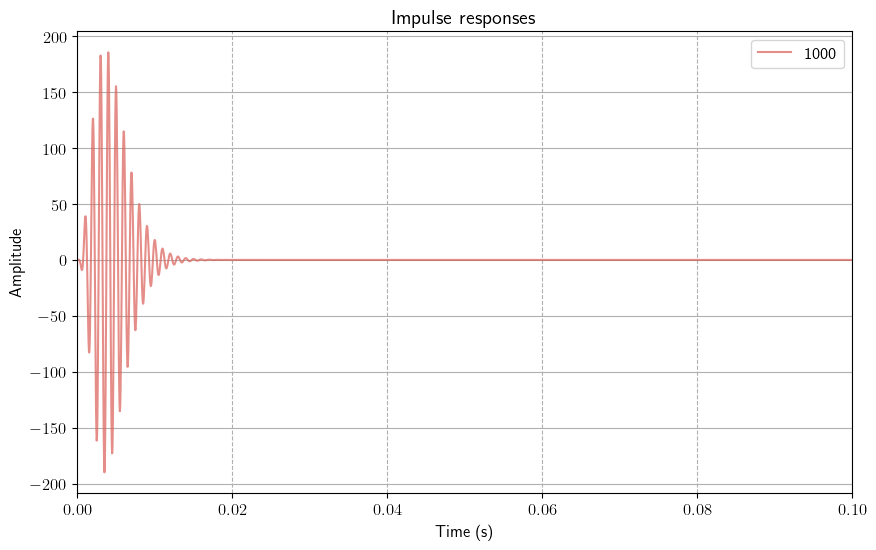

Impaired filterbank


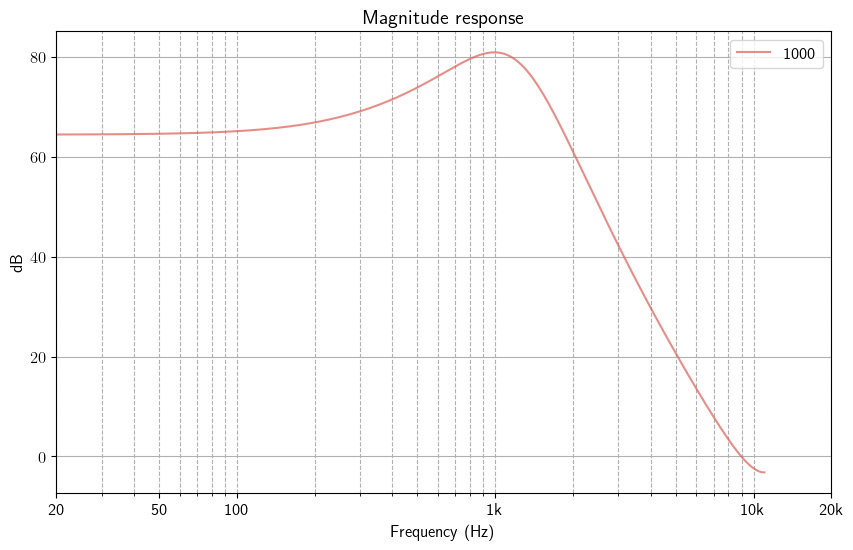

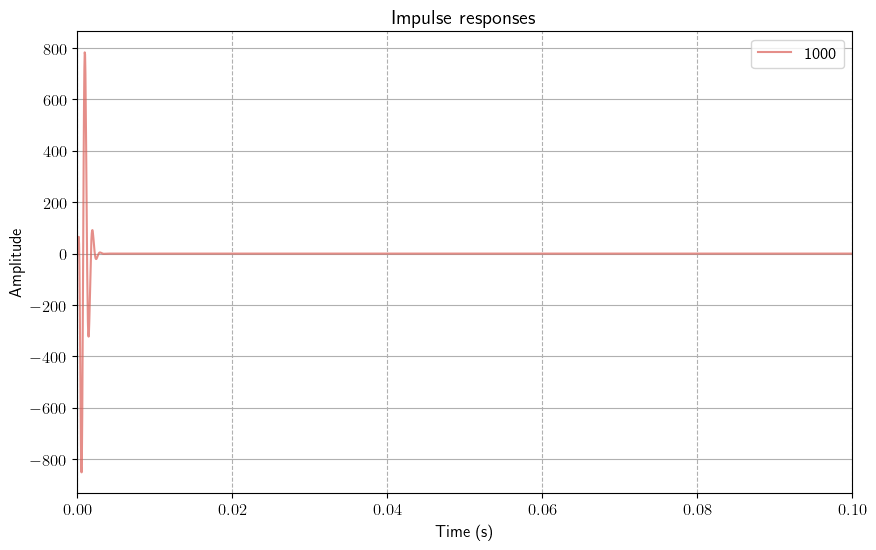

In [4]:
# initiate a normal hearing gammatone filterbank
filterbank_NH = GammaToneFilterbank(
    duration=0.25,
    center_frequencies=center_frequencies,
    fs_hz=samplerate,
    delta_q=0,
)

# initiate a impaired gammatone filterbank
filterbank_HI = GammaToneFilterbank(
    duration=0.25,
    center_frequencies=center_frequencies,
    fs_hz=samplerate,
    delta_q=5,
)


print("Normal hearing filterbank")
plot_gammabank(filterbank_NH,center_frequencies=center_frequencies)
print("Impaired filterbank")
plot_gammabank(filterbank_HI,center_frequencies=center_frequencies)

In [5]:
import torch.optim as optim

model = MyModel_v1(
    num_taps=taps,
    samplerate=samplerate, 
    center_frequencies=center_frequencies,
    delta_q=5,
)

print(model)
print(model.parameters())

for param in model.parameters():
    print(param.shape)

MyModel_v1(
  (normal_model): HearingModel(
    (gamma_bank): GammaToneFilterbank(
      (filters): ModuleList(
        (0): GammaToneFilter()
      )
    )
  )
  (impaired_model): HearingModel(
    (gamma_bank): GammaToneFilterbank(
      (filters): ModuleList(
        (0): GammaToneFilter()
      )
    )
  )
  (hearing_aid_model): FIRFilter1D()
)
<generator object Module.parameters at 0x0000021CBD929E70>
torch.Size([160, 1])


In [6]:
import torchaudio

audio, samplerate = torchaudio.load(r"..\audio\examples\Human_voice\1.wav")
audio_play(audio,samplerate=samplerate)

In [7]:
batch_size = 1
n_channels, n_samples = audio.shape
audio = audio.reshape((batch_size,n_channels,n_samples))

input audio


normal hearing  output


impaired output


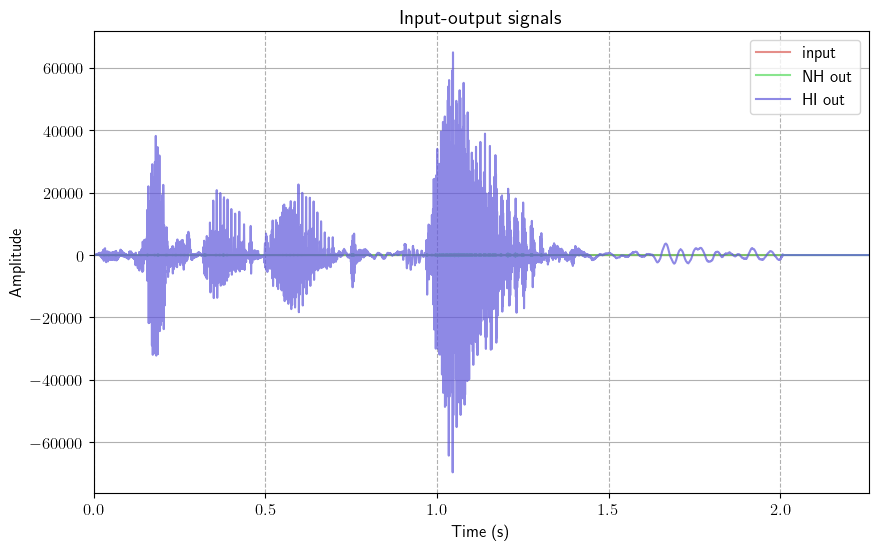

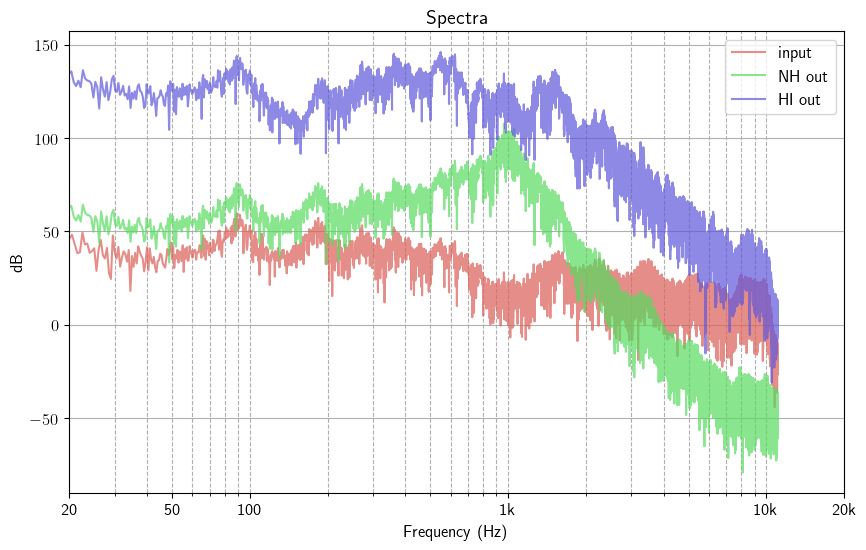

In [8]:
x_noise = torch.randn(n_batch, n_channels, n_samples)  # Input of length 10, all zeros
x_noise[:,:,10000:] = 0.0  # Input of length 10, all zeros
x_d = torch.zeros(n_batch, n_channels, n_samples)  # Input of length 10, all zeros
x_d[:, :, 0:1000] = 1.0  # Impulse

# choose which signal to excite with
x = audio

# out_NH, out_HI = model(xnoise)
out_NH, out_HI = model(x)

print("input audio")
audio_play(batch_2_np(x),samplerate)
print("normal hearing  output")
audio_play(batch_2_np(out_NH),samplerate)
print("impaired output")
audio_play(batch_2_np(out_HI),samplerate)


signals = [
    batch_2_np(x),
    batch_2_np(out_NH),
    batch_2_np(out_HI),
]

plot_time_and_spec(signals,samplerate=samplerate,
                   labels= ['input','NH out', 'HI out'])


In [9]:
import torch.optim as optim
from torchmetrics import ScaleInvariantSignalDistortionRatio

import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
from scipy import signal

from torchaudio.transforms import MFCC

do_plot = False


def abs_stft_loss(target, estimate, n_fft=2048, hop_length=1024):
    '''https://static1.squarespace.com/static/5554d97de4b0ee3b50a3ad52/t/5fb1e9031c7089551a30c2e4/1605495044128/DMRN15__auraloss__Audio_focused_loss_functions_in_PyTorch.pdf'''
    batch_size, _, n_samples = estimate.shape

    # reshape audio signal for stft function
    target = target.reshape((batch_size, n_samples))
    estimate = estimate.reshape((batch_size, n_samples))

    # compute stfts for each batch
    spec_target = torch.stft(
        target, n_fft=n_fft, hop_length=hop_length, return_complex=True
    )
    spec_estimate = torch.stft(
        estimate, n_fft=n_fft, hop_length=hop_length, return_complex=True
    )

    # convert to dB
    spec_target_dB = torch.abs(spec_target)
    spec_estimate_dB = torch.abs(spec_estimate)

    loss = torch.mean(torch.abs(spec_target_dB - spec_estimate_dB))

    return loss


def time_avg_loss(target, estimate, n_fft=2048, hop_length=1024):
    '''https://static1.squarespace.com/static/5554d97de4b0ee3b50a3ad52/t/5fb1e9031c7089551a30c2e4/1605495044128/DMRN15__auraloss__Audio_focused_loss_functions_in_PyTorch.pdf'''
    batch_size, _, n_samples = estimate.shape

    # reshape audio signal for stft function
    target = target.reshape((batch_size, n_samples))
    estimate = estimate.reshape((batch_size, n_samples))

    # compute stfts for each batch
    spec_target = torch.stft(
        target, n_fft=n_fft, hop_length=hop_length, return_complex=True
    )
    spec_target = torch.mean(spec_target,dim=-1)
    spec_estimate = torch.stft(
        estimate, n_fft=n_fft, hop_length=hop_length, return_complex=True
    )
    spec_estimate = torch.mean(spec_estimate,dim=-1)

    # convert to dB
    spec_target_dB = torch.abs(spec_target)
    spec_estimate_dB = torch.abs(spec_estimate)

    loss = torch.mean(torch.abs(spec_target_dB - spec_estimate_dB))

    return loss


def abs_fft_loss(target, estimate):
    batch_size, _, n_samples = estimate.shape

    # reshape audio signal for stft function
    target = target.reshape((batch_size, n_samples))
    estimate = estimate.reshape((batch_size, n_samples))

    fft_target = torch.abs(torch.fft.fft(target))
    fft_estimate = torch.abs(torch.fft.fft(estimate))
    loss = torch.mean(torch.abs(fft_target - fft_estimate))
    return loss


def abs_fft_loss(target, estimate):
    batch_size, _, n_samples = estimate.shape

    # reshape audio signal for stft function
    target = target.reshape((batch_size, n_samples))
    estimate = estimate.reshape((batch_size, n_samples))

    fft_target = torch.abs(torch.mean(torch.fft.fft(target)))
    fft_estimate = torch.abs(torch.fft.fft(estimate))
    loss = torch.mean(torch.abs(fft_target - fft_estimate))
    return loss


def abs_mfcc_loss(target, estimate):
    batch_size, _, n_samples = estimate.shape
    mfcc = MFCC(sample_rate=samplerate)

    # reshape audio 
    target = target.reshape((batch_size, n_samples))
    estimate = estimate.reshape((batch_size, n_samples))

    mfcc_target = mfcc(target)
    mfcc_estimate = mfcc(estimate)
    loss = torch.mean(torch.abs(mfcc_target - mfcc_estimate))

    return loss

input_data = x 

# Loss function and optimizer
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = ScaleInvariantSignalDistortionRatio()

if do_plot:
    fig, ax = plt.subplots(ncols=3,nrows=1,figsize=(10, 6))


if not 'loss_curve' in locals():
    loss_curve=[]
    
# Dummy training loop
num_epochs = 1200
for epoch in range(num_epochs):
    total_loss = 0.0

    # Forward pass and compute loss 
    out_NH, out_HI = model(input_data)
    # loss = -criterion(out_HI, out_NH)
    # loss = abs_stft_loss(out_NH, out_HI)
    loss = time_avg_loss(out_NH, out_HI)
    # loss = abs_mfcc_loss(out_NH, out_HI)
    # loss = abs_fft_loss(out_NH, out_HI)
    # loss = torch.mean(torch.square(out_NH-out_HI))
    

    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    loss_curve.append(loss.item())

    
    if do_plot:
        coeffs = model.hearing_aid_model.filter_taps.detach().numpy()
        
        w, h = signal.freqz(coeffs)
        # Clear the previous plot
        ax[0].clear()
        ax[1].clear()
        ax[2].clear()

        ax[1].stem(coeffs)
        plot.magspec_anim(ax=ax,freq_axes=[w /(2*np.pi) * samplerate], spec_axes=[h])
        
        ax[1].set_xlabel('Amplitude')
        ax[1].set_ylabel('$n$')
        
        ax[2].plot(loss_curve)
        plt.suptitle(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss}")
        signals = [
            batch_2_np(xx),
            batch_2_np(out_NH),
            batch_2_np(out_HI),
        ]
        plt.tight_layout()
        # Display the updated plot in the note
        # book
        display(fig)
        
        clear_output(wait=True)
    else:
        # Print the loss for this epoch
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss}")


Epoch 1/1200, Loss: 8293.1259765625
Epoch 2/1200, Loss: 8271.779296875
Epoch 3/1200, Loss: 8250.4482421875
Epoch 4/1200, Loss: 8229.126953125
Epoch 5/1200, Loss: 8207.8193359375
Epoch 6/1200, Loss: 8186.52197265625
Epoch 7/1200, Loss: 8165.24072265625
Epoch 8/1200, Loss: 8143.96826171875
Epoch 9/1200, Loss: 8122.7119140625
Epoch 10/1200, Loss: 8101.466796875
Epoch 11/1200, Loss: 8080.23779296875
Epoch 12/1200, Loss: 8059.02294921875
Epoch 13/1200, Loss: 8037.82275390625
Epoch 14/1200, Loss: 8016.6357421875
Epoch 15/1200, Loss: 7995.4638671875
Epoch 16/1200, Loss: 7974.30810546875
Epoch 17/1200, Loss: 7953.16650390625
Epoch 18/1200, Loss: 7932.04052734375
Epoch 19/1200, Loss: 7910.9306640625
Epoch 20/1200, Loss: 7889.8359375
Epoch 21/1200, Loss: 7868.75830078125
Epoch 22/1200, Loss: 7847.697265625
Epoch 23/1200, Loss: 7826.65087890625
Epoch 24/1200, Loss: 7805.62158203125
Epoch 25/1200, Loss: 7784.60986328125
Epoch 26/1200, Loss: 7763.61279296875
Epoch 27/1200, Loss: 7742.6337890625
Epo

Text(0, 0.5, 'Loss')

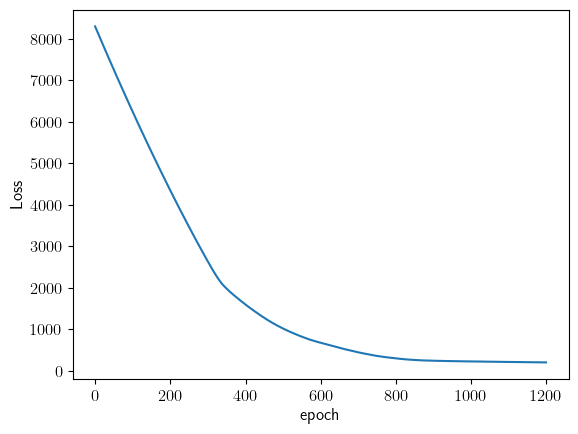

In [10]:
plt.plot(loss_curve)
plt.xlabel("epoch")
plt.ylabel("Loss")

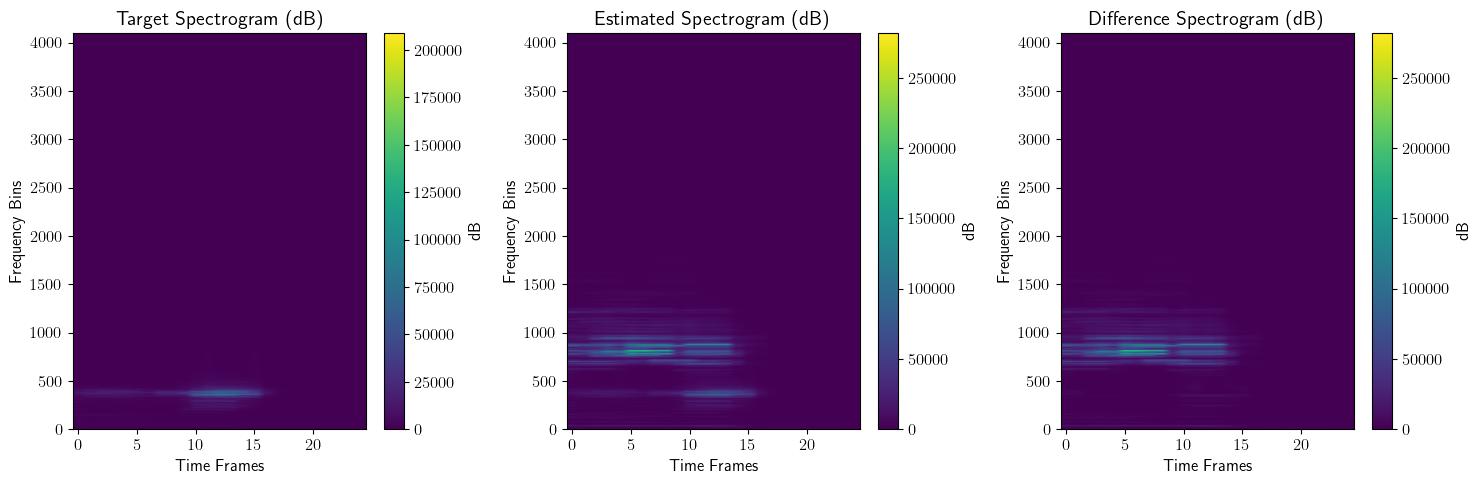

In [11]:
import matplotlib.pyplot as plt

def spectral_loss_plot(target, estimate, n_fft=1024*8, hop_length=1024*2):
    batch_size, _, n_samples = estimate.shape

    # reshape audio signal for stft function
    target = target.reshape((batch_size, n_samples))
    estimate = estimate.reshape((batch_size, n_samples))

    # compute stfts for each batch
    spec_target = torch.stft(
        target, n_fft=n_fft, hop_length=hop_length,return_complex=True
    )
    spec_estimate = torch.stft(
        estimate, n_fft=n_fft, hop_length=hop_length,return_complex=True
    )

    # convert to dB
    spec_mag_dB = (torch.abs(spec_target) + 1e-6)
    spec_estimate_dB = (torch.abs(spec_estimate) + 1e-6)

    diff = torch.abs(spec_mag_dB - spec_estimate_dB)

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot target spectrogram
    im1 = axes[0].imshow(spec_mag_dB[0].detach().numpy(), cmap='viridis', origin='lower', aspect='auto')
    axes[0].set_title('Target Spectrogram (dB)')
    axes[0].set_xlabel('Time Frames')
    axes[0].set_ylabel('Frequency Bins')
    plt.colorbar(im1, ax=axes[0], label='dB')

    # Plot estimated spectrogram
    im2 = axes[1].imshow(spec_estimate_dB[0].detach().numpy(), cmap='viridis', origin='lower', aspect='auto')
    axes[1].set_title('Estimated Spectrogram (dB)')
    axes[1].set_xlabel('Time Frames')
    axes[1].set_ylabel('Frequency Bins')
    plt.colorbar(im2, ax=axes[1], label='dB')

    # Plot difference spectrogram
    im3 = axes[2].imshow(diff[0].detach().numpy(), cmap='viridis', origin='lower', aspect='auto')
    axes[2].set_title('Difference Spectrogram (dB)')
    axes[2].set_xlabel('Time Frames')
    axes[2].set_ylabel('Frequency Bins')
    plt.colorbar(im3, ax=axes[2], label='dB')

    plt.tight_layout()
    plt.show()

# Example usage:
spectral_loss_plot(out_NH, out_HI)


input audio


normal hearing  output


impaired output


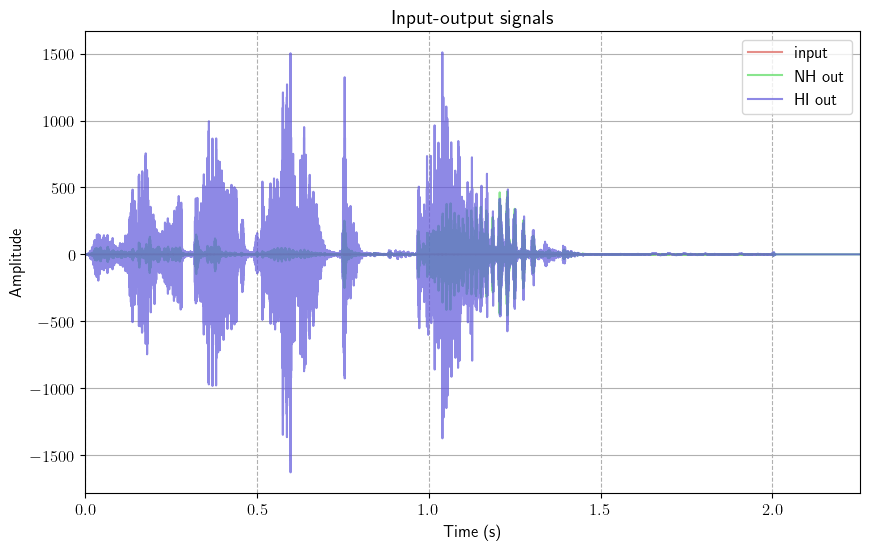

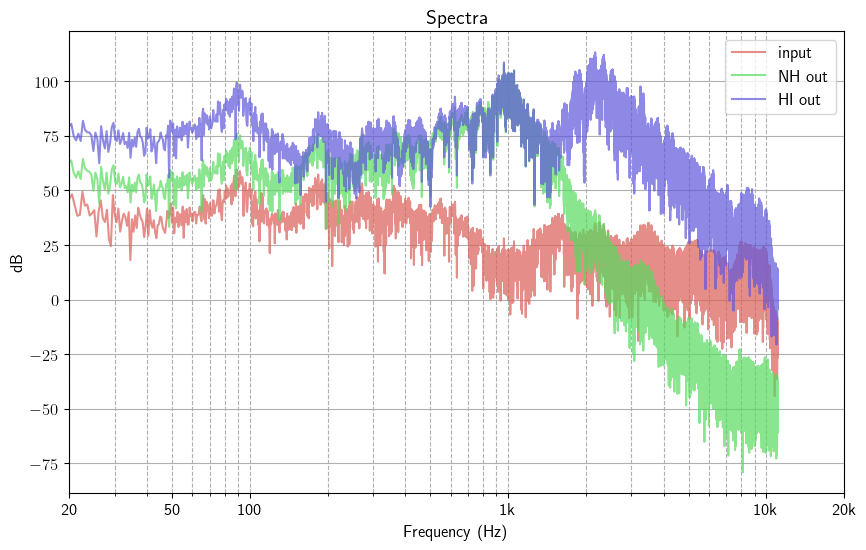

In [12]:
# out_NH, out_HI = model(x_noise)
out_NH, out_HI = model(x)
print("input audio")
audio_play(batch_2_np(x),samplerate)
print("normal hearing  output")
audio_play(batch_2_np(out_NH),samplerate)
print("impaired output")
audio_play(batch_2_np(out_HI),samplerate)

signals = [
    batch_2_np(x),
    batch_2_np(out_NH),
    batch_2_np(out_HI),
]

plot_time_and_spec(signals,samplerate=samplerate,
                   labels= ['input','NH out', 'HI out'])

In [13]:
import numpy as np
from scipy.linalg import toeplitz
from scipy import signal

def xcorr(x, y, k):
    N = min(len(x),len(y))
    r_xy = (1/N) * signal.correlate(x,y,'full') # reference implementation is unscaled
    return r_xy[N-k-1:N+k]

def snr_db(signal,noise):
    return 10*np.log10(power(signal) / power(noise))

def power(signal):
    return np.sum(signal**2)

def mse(true,pred):
    return np.mean(np.square(true-pred))

L = taps
x_ = batch_2_np(filterbank_HI(x)[0])
s = batch_2_np(filterbank_NH(x)[0])
r_xx = xcorr(x_, x_, L-1)
R_xx = toeplitz(r_xx[L-1:])
r_sx = xcorr(s, x_, L-1)
theta = np.linalg.solve(R_xx, r_sx[L-1:])


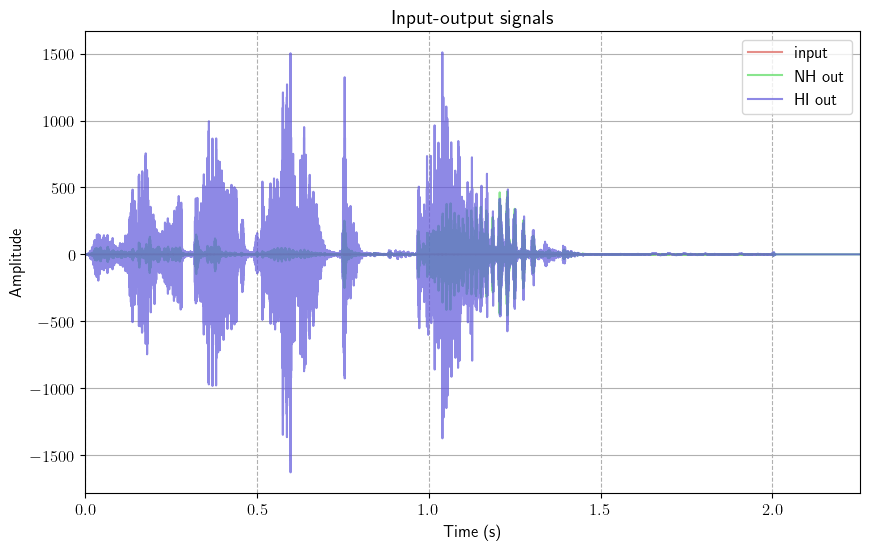

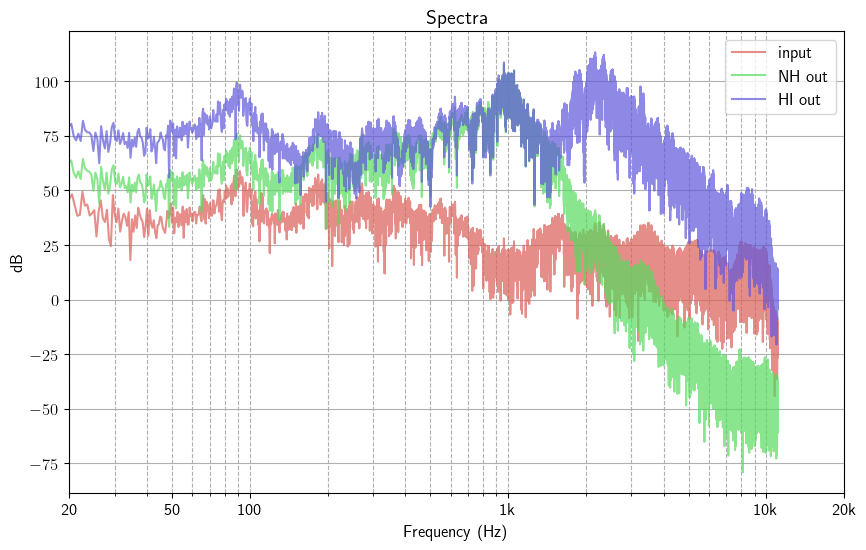

In [14]:
signals = [
    batch_2_np(x),
    batch_2_np(out_NH),
    batch_2_np(out_HI),
]

plot_time_and_spec(signals,samplerate=samplerate,
                   labels= ['input','NH out', 'HI out'])


Inspect predicted filter

<StemContainer object of 3 artists>

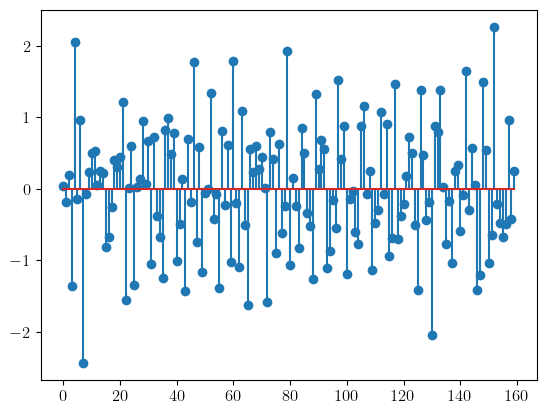

In [15]:
coeffs = model.hearing_aid_model.filter_taps.detach().numpy()
plt.stem(coeffs)

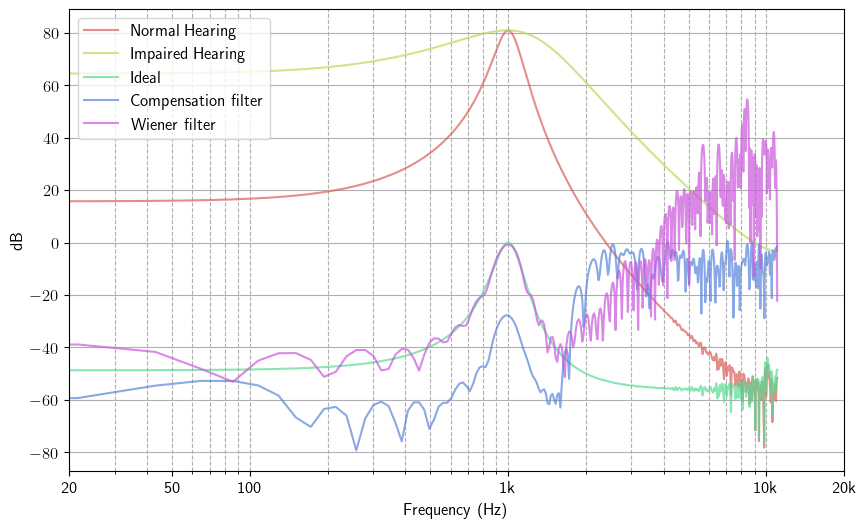

In [16]:
from scipy import signal 
freq_axes = []
spec_axes = []
time_signals = []
    
for filter in filterbank_NH.filters:
    h, f = utils.get_spectrum(filter.impulse_response, samplerate=samplerate)
    freq_axes.append(f)
    spec_axes.append(h)
    time_signals.append(filter.impulse_response)
for filter in filterbank_HI.filters:
    h, f = utils.get_spectrum(filter.impulse_response, samplerate=samplerate)
    freq_axes.append(f)
    spec_axes.append(h)
    time_signals.append(filter.impulse_response)
    
for filterhi,filternh in zip(filterbank_HI.filters,filterbank_NH.filters):
    hnh, f = utils.get_spectrum(filternh.impulse_response, samplerate=samplerate)
    hhi, f = utils.get_spectrum(filterhi.impulse_response, samplerate=samplerate)
    h = hnh/hhi
    freq_axes.append(f)
    spec_axes.append(h)
    time_signals.append(filter.impulse_response)
    

w, h = signal.freqz(coeffs)
freq_axes.append(w/(2*pi)*samplerate)
spec_axes.append(h / max(h))


w, h = signal.freqz(theta)
freq_axes.append(w/(2*pi)*samplerate)
spec_axes.append(h)
# Plot IR in time-domain and magnitude repsonse
plot.magspec(
    freq_axes=freq_axes,
    spec_axes=spec_axes,
    labels=["Normal Hearing","Impaired Hearing","Ideal", "Compensation filter", "Wiener filter"]
)

In [17]:
from scipy.signal import lfilter
print("wiener filter")
audio_play(lfilter(theta,1,batch_2_np(out_HI)),samplerate)
print("normal hearing  output")
audio_play(batch_2_np(out_NH),samplerate)
print("impaired output")
audio_play(batch_2_np(out_HI),samplerate)


wiener filter


normal hearing  output


impaired output


In [18]:
criterion(torch.tensor(lfilter(theta,1,batch_2_np(out_HI))),out_NH[0][0])



tensor(-12.8985)